# Stochastically Structured Reservoir Computers (SSRC)

This notebook contains the prototypical algorithms and computational examples described Section 4 in the paper *Stochastically Structured Reservoir Computers for Financial and Economic System Identification* (2025). Specifically, this Jupyter Notebook includes sections 5.1, corresponding to:

1. **Computational Example 1**: *Preference evolution for an investment coalition: A Dynamic and Behavioral Approach*.

SSRC consists of a collection of functions written in Python that can be used for stochastically structured reservoir computing for identification and numerical simulation of economic and financial dynamical systems.

The numerical experiments programmed in this notebook use synthetic and real data for stochastically structured reservoir computer based model identification.

## Components of Algorithm 2: SSRC Model Identification

In [32]:
from numpy import ones,zeros
from matplotlib.pyplot import plot, spy,subplot,grid,axis
from numpy.linalg import pinv
from networkx import draw_networkx, DiGraph, circular_layout

In [2]:
"""
Created on Wed Jul 13 15:47:34 2022
RFactor
@author: doctor
"""

def SRFactor(s,L,tp,method = "random",tol = 1e-15, scale = 1e0):
    from numpy import zeros, where, vstack
    sL = s*L
    if method == "random":
        from numpy.random import randn
        z = scale*randn(sL,1)
        z = NLMap(z, tp)
        z[-1] = scale*randn()
    elif method == "prime":
        from PrimeGenerator import PrimeGenerator
        z0 = PrimeGenerator(sL+1,int(sL/2))
        z = NLMap(z0[:-1], tp)
        z[-1] = z0[-1]
    N = int((sL**(tp+1)-sL)/(sL-1))+1
    w0 = zeros((1,N))
    R = w0.copy()
    R[0,0] = 1
    for j in range(1,N):
        f = where(abs(z-z[j])<tol)
        if f[0][0] == j:
            w0[0,f] = 1
            R = vstack((R,w0))
            w0[0,f] = 0
    return R

In [3]:
"""
Created on Fri Sept 29 15:27:32 2022
NLMap Nonlinear data mapping
   Code by Fredy Vides
   For Paper, "Approximating equivariant evolution operators with
   recurrent reservoir computers"
   by F. Vides
@author: Fredy Vides
"""

def NLMap(x,tp):
    from numpy import append, kron
    p = x
    q = p
    for k in range(tp-1):
        q = kron(x,q)
        p = append(p,q)
    p = append(p,1)
    return p

In [4]:
def nnspsolver(A,Y,L=100,nz=100,delta=1e-2,tol=1e-3):
    from numpy.linalg import lstsq
    from scipy.optimize import nnls
    from numpy.linalg import svd,norm
    from numpy import zeros,dot,argsort,inf
    N = A.shape[1]
    if nz<0:
        nz = N
    X=zeros((N,1))
    X0 = X.copy()
    X0[:,0] = nnls(A,Y)[0]
    w=zeros((N,))
    K=1
    Error=1+tol
    c=X0[:,0]
    x0=c
    ac=abs(c)
    f=argsort(-ac)
    N0=int(min(sum(ac[f]>delta),nz))
    while (K<=L) & (Error>tol):
        ff=f[:N0]
        X[:,0]=w
        c = nnls(A[:,ff],Y)[0]
        X[ff,0]=c
        Error=norm(x0-X[:,0],inf)
        x0=X[:,0]
        ac=abs(x0)
        f=argsort(-ac)
        N0=int(min(sum(ac[f]>delta),nz))
        K=K+1
    return X

In [5]:
def SSRep(datos_ent,datos_sal,ss,delta=1e-6,tol=1e-3):
    from numpy import kron, identity, diag
    n0 = datos_ent.shape[0]
    n1 = datos_sal.shape[0]
    S0 = datos_ent[:,:ss]
    S0 = kron(S0,identity(n1)).T
    S1 = S0.T@((datos_sal[:,1:(1+ss)]).T).reshape(ss*n1)
    C = kron(identity(n0),ones((1,n1)))
    Mr = zeros((n0*n1+n0,n0*n1))
    Mr[:n0*n1,:] = S0.T@S0
    Mr[n0*n1:,:] = C
    rhs = zeros((n1*n0+n0))
    rhs[:n1*n0] = S1
    rhs[n1*n0:] = 1
    c = zeros((n0*n1,1))
    c[:,:1] = nnspsolver(Mr,rhs,delta=delta,tol=tol,nz=len(rhs))
    Pr = c.reshape(n0,n1).T
    Pr = Pr@diag(1/sum(Pr))
    return Pr

In [6]:
def SSRep_2(data_in,data_out,SM=1,sample_size=39,delta = 1e-6,tol=1e-3,nz = 100):
    from numpy import isscalar, zeros, where, diag
    from scipy.optimize import nnls
    n0 = data_out.shape[0]
    m0 = data_in.shape[0]
    E0 = zeros((n0,m0))
    A = E0.copy()
    D = data_in[:,:sample_size]
    X1 = data_out[:,1:(sample_size+1)]
    X1 = (X1.T).reshape(sample_size*n0)
    Index = E0.copy()
    if isscalar(SM):
        A0 = zeros((n0,m0))
        A0[:,:] = 1
    else:
        A0 = SM
    indices = where(A0.T)
    Index[indices[1],indices[0]] = range(len(indices[0]))
    Index = Index.astype('int')
    n = len(indices[0])
    X0 = zeros((sample_size*n0,n))
    for k in range(n):
            E0[indices[1][k],indices[0][k]] = 1
            X0[:,k] = ((E0@D).T).reshape(sample_size*n0)
            E0[indices[1][k],indices[0][k]] = 0
    C = zeros((m0,n))
    for l in range(m0):
        C[l,Index[where(A0[:,l]),l]] = 1
    Mr = zeros((n+m0,n))
    Mr[:n,:n] = X0.T@X0
    Mr[n:,:n] = C
    rhs = zeros((n+m0,1))
    rhs[:n,0] = X0.T@X1
    rhs[n:,0] = 1
    a = nnspsolver(Mr,rhs[:,0],delta=delta,tol=tol,nz=len(rhs))#nnls(Mr,rhs[:,0])[0]
    A[indices[1],indices[0]] = a[:,0]
    sumA=sum(A)
    sumA[where(sumA==0)[0]]=1
    A = A@diag(1/sumA)
    return A

# Computational example 1

In [7]:
def modelo_cdi(N,p=0.5):
    from numpy import zeros
    A = zeros((N+1,N+1))
    A[0,0] = A[N,N] = 1
    for j in range(N-1):
        A[j+1,j] = 1-p
        A[j+1,j+2] = p
    return A

In [8]:
# Portfolio account numbers
N = 5
# Portfolio account choice P-parameter
p = 0.55
# Simulation time horizon
T = 100

In [9]:
A = modelo_cdi(N-1,p).T

In [10]:
A

array([[1.  , 0.45, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.45, 0.  , 0.  ],
       [0.  , 0.55, 0.  , 0.45, 0.  ],
       [0.  , 0.  , 0.55, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.55, 1.  ]])

In [11]:
Ap = zeros((5,8))
Ap[:,:5] = A

In [12]:
def phi(x,s):
    from numpy import zeros
    q = zeros(8)
    q[:5] = s[0]*x
    q[5] = s[1]*x[0]*x[1]
    q[6] = s[1]*x[2]*x[4]
    q[7] = s[1] - q[5] - q[6]
    return q

In [13]:
p = zeros((5,100))
pxp = zeros((8,100))
p[:,0] = [0.25,0.5,0.25,0,0]
s = [0.9,0.1]
pxp[:,0] = phi(p[:,0],s)
for k in range(99):
    p[:,k+1] = 0.9*A@p[:,k]
    p[0,k+1] = p[0,k+1]+0.1*(0.8*p[0,k]*p[1,k]+0.1*p[2,k]*p[4,k])
    p[4,k+1] = p[4,k+1]+0.1*(0.2*p[0,k]*p[1,k]+0.9*p[2,k]*p[4,k]+1*(1-(p[0,k]*p[1,k]+p[2,k]*p[4,k])))
    pxp[:,k+1] = phi(p[:,k+1],s)

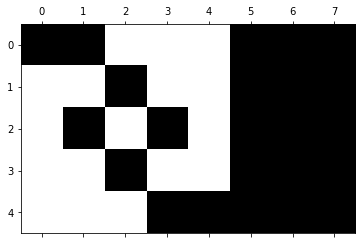

In [14]:
from numpy import ones 
SWp = ones((5,8))
SWp[:,:5] = (A>1e-10)*SWp[:,:5]
spy(SWp)

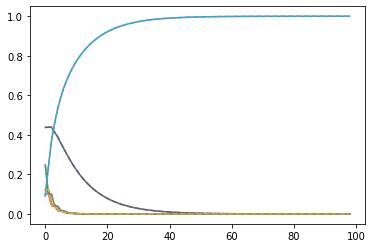

In [15]:
Wp = SSRep(pxp,p,ss=40,delta=1e-2)
plot(p[:,1:].T);plot((Wp@pxp[:,:-1]).T,'--')

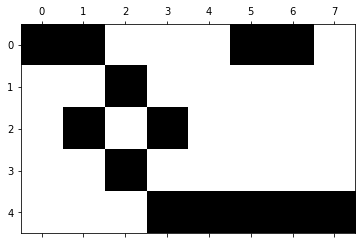

In [16]:
spy(Wp)

In [17]:
Wp

array([[1.  , 0.45, 0.  , 0.  , 0.  , 0.8 , 0.1 , 0.  ],
       [0.  , 0.  , 0.45, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.55, 0.  , 0.45, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.55, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.55, 1.  , 0.2 , 0.9 , 1.  ]])

In [18]:
Wp1 = SSRep_2(pxp,p,sample_size=30,delta=1e-6,SM=(abs(Wp)>1e-10))

In [19]:
Wp1

array([[1.  , 0.45, 0.  , 0.  , 0.  , 0.8 , 0.1 , 0.  ],
       [0.  , 0.  , 0.45, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.55, 0.  , 0.45, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.55, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.55, 1.  , 0.2 , 0.9 , 1.  ]])

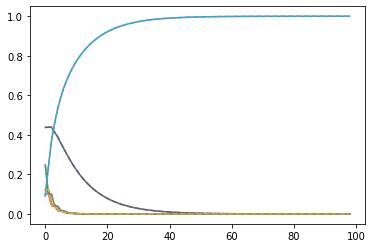

In [20]:
plot(p[:,1:].T);plot((Wp1@pxp[:,:-1]).T,'--')

In [21]:
Wp2 = p[:,1:31]@pinv(pxp[:,:30])

In [22]:
sum(Wp2)

array([1.08870968, 1.08870968, 1.08870968, 1.08870968, 1.08870968,
       0.2016129 , 0.2016129 , 0.2016129 ])

In [23]:
Wp2 = (abs(Wp2)>1e-15)*Wp2
Wp2

array([[ 1.02681452,  0.47681452,  0.02681452,  0.02681452,  0.02681452,
         0.55866935, -0.14133065, -0.24133065],
       [-0.00181452, -0.00181452,  0.44818548, -0.00181452, -0.00181452,
         0.01633065,  0.01633065,  0.01633065],
       [-0.00403226,  0.54596774, -0.00403226,  0.44596774, -0.00403226,
         0.03629032,  0.03629032,  0.03629032],
       [-0.00221774, -0.00221774,  0.54778226, -0.00221774, -0.00221774,
         0.01995968,  0.01995968,  0.01995968],
       [ 0.06995968,  0.06995968,  0.06995968,  0.61995968,  1.06995968,
        -0.4296371 ,  0.2703629 ,  0.3703629 ]])

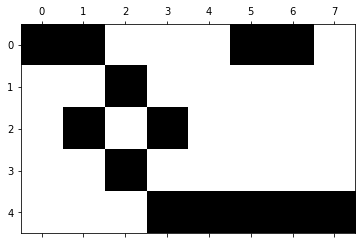

In [24]:
spy(Wp1)

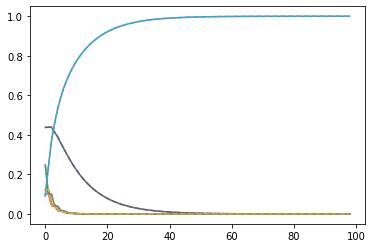

In [25]:
plot(p[:,1:].T);plot((Wp2@pxp[:,:-1]).T,'--')

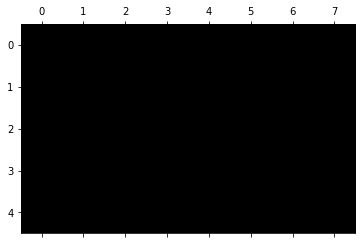

In [26]:
spy(Wp2)

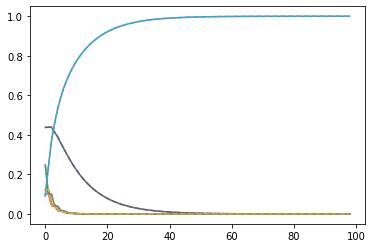

In [27]:
plot(p[:,1:].T);plot((Wp2@pxp[:,:-1]).T,'--')

In [28]:
p0 = zeros((5,100))
p0[:,0] = p[:,0]
pxp0=zeros(8)
for j in range(99):
    pxp0 = phi(p0[:,j],[0.9,0.1])
    p0[:,j+1] = Wp1@pxp0

In [29]:
def RelGraph(GMatrix):
    from numpy import where, hstack
    GMatrix = GMatrix.T
    nodes = []
    edges = []
    st = []
    tt = []
    for j in range(GMatrix.shape[0]):
        f0 = where(GMatrix[j,:]>0)[0]
        nodes.append(j)
        tt = hstack((tt,f0))
        st = hstack((st,j*ones(len(f0))))

    st = st.astype('int')
    tt = tt.astype('int')
    for k in range(len(st)):
        edges.append((st[k],tt[k]))

    G = DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

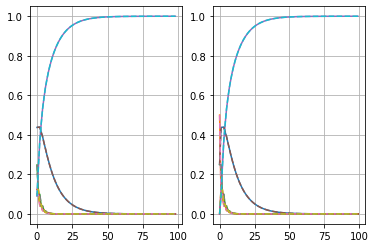

In [30]:
subplot(1,2,1),plot(p[:,1:].T);plot((Wp1@pxp[:,:-1]).T,'--');grid('On');
subplot(1,2,2);plot(p.T);plot(p0.T,'--');grid('On');

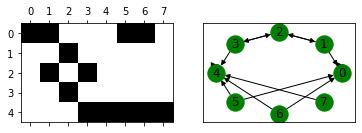

In [33]:
Wpc = zeros((Wp1.shape[1],Wp1.shape[1]))
Wpc[:Wp1.shape[0],:] = Wp1
G = RelGraph(Wpc)
subplot(2,2,1),spy(Wp1),axis('tight');
pos = circular_layout(G)
subplot(2,2,2),draw_networkx(G,node_color = 'green',pos = pos),axis('tight');

# References
1. Banegas, L., Vides. F. Stochastically Structured Reservoir Computers for Financial and Economic System Identification. arXiv:2507.17115 [math.OC]
2. Vides, F., Nogueira, I., Lopez Gutierrez, G., Banegas, L., Flores, E. (2025). Identifying Systems with Symmetries using Equivariant Autoregressive Reservoir Computers. arXiv:2311.09511 [eess.SY]